# Simple Multi AI Agent Architecture

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [5]:
from langchain.chat_models import init_chat_model

llm= init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000193CAD60050>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000193CAD60D70>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
llm.invoke("Hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [49]:
from langgraph.graph import MessagesState

In [51]:
# Define the state
class AgentState(MessagesState):
    next_agent: str #Which agent should go next

In [52]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchResults

In [53]:
# Create Simple tool
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Using Tavily for web search

    search= TavilySearchResults(max_results=3)
    results= search.invoke(query)

    return str(results)

@tool
def write_summary(content: str) -> str:
    """Write a summary of the provided content."""
    # Simple summary generation

    summary= f"Summary of findings:\n\n{content[:500]}"

    return summary

In [54]:
from langchain_core.messages import SystemMessage

In [55]:
# Define agent functions (simpler approach)
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""

    messages= state["messages"]

     # Add system message for context
    system_msg= SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")

    # Call LLM with tools
    tools= [search_web]
    researcher_llm= llm.bind_tools(tools)
    response= researcher_llm.invoke([system_msg] + messages)

    # Return the response and route to writer
    return{
        "messages": [response],
        "next_agent": "writer"
    }

In [56]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""

    messages= state["messages"]

    # Add system message
    system_msg= SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")

     # Simple completion without tools
    response= llm.invoke([system_msg] + messages)


    return {
        "messages": [response], 
        "next_agent": "end"
    }

In [57]:
from langgraph.prebuilt import ToolNode

In [ ]:
# # Tool executor node
# def execute_tools(state: AgentState):
#     """Execute any pending tool calls"""
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     # Check if there are tool calls to execute
#     if hasattr(last_message, "tool_calls") and last_message.tool_calls:
#         # Create tool node and execute
#         tool_node = ToolNode([search_web, write_summary])
#         response = tool_node.invoke(state)
#         return response
    
#     # No tools to execute
#     return state

In [59]:
from langgraph.graph import MessagesState, StateGraph, START, END

# Build Graph
workflow= StateGraph(MessagesState)

# Add Nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)

final_workflow= workflow.compile()

# final_workflow

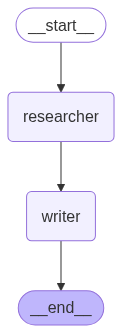

In [17]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(final_workflow.get_graph(xray=True).draw_mermaid_png()))

In [60]:
final_workflow.invoke({"messages": "Reasearch about the usecase of agentic ai in business"})

{'messages': [HumanMessage(content='Reasearch about the usecase of agentic ai in business', additional_kwargs={}, response_metadata={}, id='f5a519c7-fb3f-4756-96c8-853f71b8d203'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'k2ezgmakf', 'function': {'arguments': '{"query":"agentic AI use cases in business"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 243, 'total_tokens': 263, 'completion_time': 0.037352569, 'prompt_time': 0.017603342, 'queue_time': 0.053006903, 'total_time': 0.054955911}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f530bb95-c3b4-4652-bb1e-2e9f05078c42-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'agentic AI use cases in business'}, 'id': 'k2ezgmakf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 243, 'output_tokens': 20, 'total_tokens': 263}),
  AIMessage(co

In [40]:
response= final_workflow.invoke({"messages": "Reasearch about the usecase of agentic ai in business"})

In [61]:
response["messages"][-1].content

' \n\n**Summary of Findings:**\n\nAgentic AI refers to artificial intelligence (AI) systems that can take initiative, make decisions, and act on their own in business environments. Research suggests that agentic AI has several potential use cases in business, including:\n\n1. **Customer Service Chatbots**: Agentic AI-powered chatbots can provide personalized customer service, proactively address issues, and resolve problems without human intervention.\n2. **Predictive Maintenance**: Agentic AI systems can analyze sensor data, predict equipment failures, and schedule maintenance, reducing downtime and increasing efficiency.\n3. **Supply Chain Optimization**: Agentic AI can analyze demand patterns, optimize inventory levels, and adjust supply chain logistics in real-time, reducing costs and improving response times.\n4. **Financial Analysis**: Agentic AI can analyze financial data, identify trends, and make recommendations for investment and risk management, enabling businesses to make d

In [62]:
print(response["messages"][-1].content)

 

**Summary of Findings:**

Agentic AI refers to artificial intelligence (AI) systems that can take initiative, make decisions, and act on their own in business environments. Research suggests that agentic AI has several potential use cases in business, including:

1. **Customer Service Chatbots**: Agentic AI-powered chatbots can provide personalized customer service, proactively address issues, and resolve problems without human intervention.
2. **Predictive Maintenance**: Agentic AI systems can analyze sensor data, predict equipment failures, and schedule maintenance, reducing downtime and increasing efficiency.
3. **Supply Chain Optimization**: Agentic AI can analyze demand patterns, optimize inventory levels, and adjust supply chain logistics in real-time, reducing costs and improving response times.
4. **Financial Analysis**: Agentic AI can analyze financial data, identify trends, and make recommendations for investment and risk management, enabling businesses to make data-driven

In [47]:
response["messages"][-1].content

' \n\n**Summary of Findings:**\n\nAgentic AI refers to artificial intelligence (AI) systems that can take initiative, make decisions, and act on their own in business environments. Research suggests that agentic AI has several potential use cases in business, including:\n\n1. **Customer Service Chatbots**: Agentic AI-powered chatbots can provide personalized customer service, proactively address issues, and resolve problems without human intervention.\n2. **Predictive Maintenance**: Agentic AI systems can analyze sensor data, predict equipment failures, and schedule maintenance, reducing downtime and increasing efficiency.\n3. **Supply Chain Optimization**: Agentic AI can analyze demand patterns, optimize inventory levels, and adjust supply chain logistics in real-time, reducing costs and improving response times.\n4. **Financial Analysis**: Agentic AI can analyze financial data, identify trends, and make recommendations for investment and risk management, enabling businesses to make d

In [48]:
print(response["messages"][-1].content)

 

**Summary of Findings:**

Agentic AI refers to artificial intelligence (AI) systems that can take initiative, make decisions, and act on their own in business environments. Research suggests that agentic AI has several potential use cases in business, including:

1. **Customer Service Chatbots**: Agentic AI-powered chatbots can provide personalized customer service, proactively address issues, and resolve problems without human intervention.
2. **Predictive Maintenance**: Agentic AI systems can analyze sensor data, predict equipment failures, and schedule maintenance, reducing downtime and increasing efficiency.
3. **Supply Chain Optimization**: Agentic AI can analyze demand patterns, optimize inventory levels, and adjust supply chain logistics in real-time, reducing costs and improving response times.
4. **Financial Analysis**: Agentic AI can analyze financial data, identify trends, and make recommendations for investment and risk management, enabling businesses to make data-driven

# Supervise Multi AI Agent Architecture